In [93]:
import numpy as np
import cv2
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas as pd

class Graph:
    #TODO implement 8-point connectivity
    def __init__(self, pixel, goal, value, g=0, parent=None):
        self.pixel = pixel
        self.goal = goal
        self.parent = parent
        self.neighbors = {'u' : None, #up
                          'l' : None, #left
                          'd' : None, #down
                          'r' : None  #right
                          }
        self.h = self.heuristic()
        self.g = g
        self.obstacle = value
        self.f = self.h + self.g + 1e4 * self.obstacle
    
    def heuristic(self):
        pixel_arr = np.array(self.pixel)
        goal_arr = np.array(self.goal)
        return np.linalg.norm(goal_arr - pixel_arr)

    def add_neighbor(self, loc, npixel, nvalue):
        self.neighbors[loc] = Graph(npixel, self.goal, nvalue, g=self.g+1, parent=self)


In [90]:
class A_star:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.shape = grid.shape
        self.start = start
        self.goal = goal
        self.graph = Graph(start, goal, grid[start[0], start[1]])
        self.O = [] # priority queue
        self.C = set() # visited nodes
        self.T = []
        self.path = None

    def _gen_path(self, node):
        curr = node
        order = []
        while curr:
            order.append(curr.pixel)
            curr = curr.parent
        self.path = order[::-1]
    
    def run(self):
        self.O.append(self.graph)
        tt = 0
        test = set()
        #ncurr = self.graph
        #self.C.append(self.graph)

        #while ncurr.pixel != self.goal:
        while self.O:
            ncurr = self.O.pop()
            self.T.append(ncurr)
            if ncurr.pixel in test:
                print(tt)
                print(test)
            test.add(ncurr.pixel)

            if ncurr.pixel == self.goal:
                #self.C.append(ncurr)
                self.O = list(filter(lambda x: x.f < ncurr.g, self.O))
            
            elif ncurr not in self.C:
                #self.C.append(ncurr)
                self.C.add(ncurr.pixel)
                if not ncurr.pixel[0] % 1:
                    pass
                    #print(ncurr.pixel, end='::')
                    #print(len(self.C), len(self.O), end=' >< ')
                for i, loc in enumerate(ncurr.neighbors.keys()):
                    move = (-1)**(0 < i < 3) * np.array([0**((i + 1) % 2), 0**(i % 2)]) # x,y
                    #move = (-1)**(0 < i < 3) * np.array([-0**(i % 2), 0**((i + 1) % 2)])  # y, x
                    next_pixel = tuple(np.array(ncurr.pixel) + move)
                    #C_pxs = [node.pixel for node in self.C]
                    O_pxs = [node.pixel for node in self.O]

                    if (next_pixel not in self.C) and (next_pixel not in O_pxs):
                        if (next_pixel[0] >= 0 and next_pixel[1] >= 0) and (next_pixel[0] < self.shape[0] 
                            and next_pixel[1] < self.shape[1]):
                                nvalue = self.grid[next_pixel[0], next_pixel[1]]
                                ncurr.add_neighbor(loc, next_pixel, nvalue)
                                self.O.append(ncurr.neighbors[loc])
                
                self.O.sort(key=lambda x : x.f, reverse=True)
                if tt == 0:
                    print([(node.pixel, node.f) for node in self.O])
            #ncurr = self.O.pop()
            tt += 1
        self._gen_path(ncurr)



In [94]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel
def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

grid_path = os.path.join('catkin_ws/src/wavefront', 'worlds/grid1.npy')
grid = np.load(grid_path)
#grid = cv2.transpose(grid)

start = (-6, 2)
start_ = meters2pixels(start)
goal = (5, 2)
goal_ = meters2pixels(goal)
mapa = grid.copy()

mapa[goal_[1], goal_[0]] = 2
mapa[start_[1], start_[0]] = 3
grid


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint64)

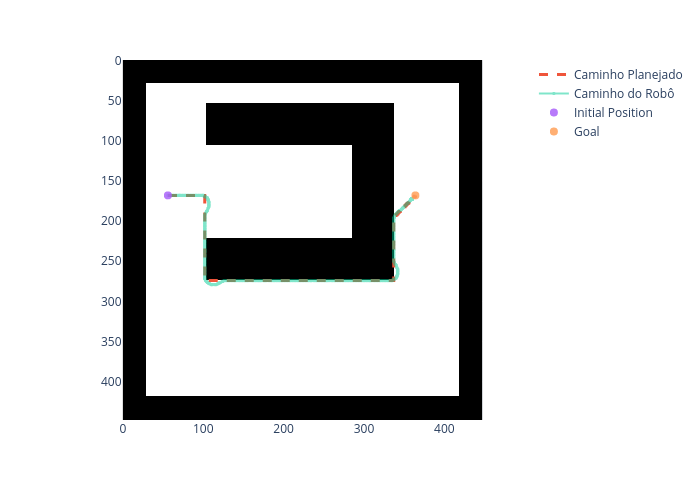

In [95]:
df = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/astar_path.csv', index_col=0)
df2 = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/astar_path2.csv', index_col=0)

aux = df2.to_numpy()
passed_px = [meters2pixels(x) for x in aux]
xpx, ypx = list(zip(*passed_px))

grid2 = cv2.imread('/home/fbartelt/Documents/UFMG/Planejamento/catkin_ws/src/Astar/worlds/maze.png', cv2.IMREAD_GRAYSCALE)
grid2 = cv2.resize(grid2, (450, 450), interpolation = cv2.INTER_AREA)
grid2 = 0**grid2.T
fig = px.imshow(0**grid.T, binary_string=True)
fig.add_trace(go.Scatter(x=df['1'], y=df['0'], name='Caminho Planejado', showlegend=True, line_width=3, line_dash='dash'))
fig.add_trace(go.Scatter(x=xpx, y=ypx, name='Caminho do Robô', showlegend=True, mode='lines+markers', marker_symbol='square-open', opacity=0.5, marker_size=2))
fig.add_trace(go.Scatter(x=[56], y=[168], name='Initial Position', mode='markers', marker_size=8, opacity=0.85))
fig.add_trace(go.Scatter(x=[364], y=[168], name='Goal', mode='markers', marker_size=8, opacity=0.85))
fig.show(renderer='png')

# Trapezoidal

In [11]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel

def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

In [28]:
import plotly.express as px
import cv2
img = cv2.imread('trapz.png', cv2.IMREAD_GRAYSCALE)
img = img / 255
fig = px.imshow(img)
fig.show()

In [29]:
corners = [
           [4, 121], [31, 110], [39, 4], [48, 56], [58, 248], [81, 28], 
           [100, 183], [143, 101], [147, 215], [174, 104], [184, 250],
           [198, 7], [218, 97], [252, 80]
           ]
corners = [tuple(x) for x in corners]
for corner in corners:
    img[corner[1], corner[0]] = 2

fig = px.imshow(img)
fig.show()

In [24]:
img[1, 1]

1.0